<a href="https://colab.research.google.com/github/kmkarakaya/ML_tutorials/blob/master/seq2seq_Part_C_Basic_Encoder_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PART C: BASIC ENCODER DECODER ARCHITECTURE/DESIGN
Welcome to the **Part C** of Seq2Seq Learning Tutorial Series.
In this tutorial, we will design a Basic Encoder Decoder model to solve the sample Seq2Seq problem introduced in **Part A**.

We will use **LSTM** as the Recurrent Neural Network layer in Keras.

If you would like to follow up all the tutorials, please **subcribe** to [my YouTube Channel](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA/playlists) or **follow** [my blog on Medium](https://medium.com/@kmkarakaya). Thank you!

# References:

**Blogs**:

* [tf.keras.layers.LSTM official website](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

* [A ten-minute introduction to sequence-to-sequence learning in Keras by Francois Chollet](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

* [How to Develop an Encoder-Decoder Model with Attention in Keras by Jason Brownlee](https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/)

**Presentations:**

* [LSTM from a programmer's perspective by Murat Karakaya Akademi](https://github.com/kmkarakaya/ML_tutorials/raw/bf15d1d5aebd23e05420c12f3c954abea9204b1f/ppt/HOW%20KERAS%20LSTM%20WORKS.pptx)

**Videos:**
* [LSTM from scratch by Murat Karakaya Akademi](https://youtu.be/7nnSjZBJVDs)

**Notebooks**:
* [LSTM intro by Murat Karakaya Akademi](https://colab.research.google.com/drive/1kG5pUczEtqdDtMHiNL-mvgTi-5-Y058t?usp=sharing)
* [Recap LSTM outputs by Murat Karakaya Akademi](https://colab.research.google.com/drive/1nUazJkXcRZi-XiXCr6sEgCy2Z5Mhze1n?usp=sharing)


# Preparation

In [2]:
#@title Check GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found: continue with CPU')
else:
  print('Found GPU at: {}'.format(device_name))

GPU device not found: continue with CPU


In [3]:
#@title Version Info
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)


tf version:  2.3.0
tf.keras version: 2.4.0


In [4]:
#@title Time
!pip install ipython-autotime

%load_ext autotime

time: 138 µs


In [5]:
#@title Import Libraries
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

time: 58.2 ms


In [23]:
#@title Functions to generate Seq2Seq Dataset, one hot encode / decode Input & Output Sequences


# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(1, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_reversed_pairs(time_steps,vocabulary_size,verbose= False):
	# generate random sequence
	sequence_in = generate_sequence(time_steps, vocabulary_size)
	sequence_out = sequence_in[::-1]
	
	# one hot encode
	X = one_hot_encode(sequence_in, vocabulary_size)
	y = one_hot_encode(sequence_out, vocabulary_size)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))

	if(verbose):
		print("\nNotes:")
		print('1. For each input sequence (X), selecting ',time_steps,
		      ' random numbers between 1 (inclusive) and ',
		      vocabulary_size, ' (exclusive) ')
		print("2. 0 is reserved as the SART Symbol")
	  
		print('\nA sample X ')
		print('X=%s' % (one_hot_decode(X[0])))
		print('\nreversed input sequence (X) is the output sequence (y) ')
		print('y=%s' % (one_hot_decode(y[0])))
	
		print('\nEach input and output sequences are converted one_hot_encoded format in ',
		      vocabulary_size,' dimensions')
		print('X=%s' % (X[0]))
		print('y=%s' % (y[0]))
	return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= False):
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
	pairs=np.array(pairs).squeeze()
	X_train = pairs[:,0]
	y_train = pairs[:,1]
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
	pairs=np.array(pairs).squeeze()
	X_test = pairs[:,0]
	y_test = pairs[:,1]	

	if(verbose):
		print('\nGenerated sequence datasets as follows (batch_size,time_steps, features)')
		print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
		print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)
	
	return X_train, y_train, X_test, 	y_test

time: 53.4 ms


In [7]:
#@title Function to Train & Test  given model (Early Stopping monitor 'val_loss')
def train_test(model, X_train, y_train , X_test, 	y_test, epochs=500, batch_size=32, patience=5,verbose=0):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
	# train model
	print('training for ',epochs,' epochs begins with EarlyStopping(monitor= val_loss, patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,batch_size=batch_size, verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	#print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, batch_size=batch_size, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()




  
	# spot check some examples
	space = 3*len(one_hot_decode(y_test[0]))
	print('10 examples from test data...')
	print('Input',' '*(space-4) ,'Expected',' '*(space-7) ,
	      'Predicted',' '*(space-5) ,'T/F')
	correct =0 
	sampleNo =  10

	predicted= model_encoder_decoder.predict(X_test[:sampleNo], batch_size=batch_size)
	for sample in range(0,sampleNo):
		if (one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample])):
			correct+=1
		print( one_hot_decode(X_test[sample]), ' ', 
					one_hot_decode(y_test[sample]),' ', one_hot_decode(predicted[sample]),
					' ',one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample]))
	print('Accuracy: ', correct/sampleNo)
	


time: 42.8 ms


# REMINDER:
* This is the **Part C** of the Seq2Seq Learning series.

* **Please check out the previous parts** to ***refresh*** the necessary background knowledge in order to follow this part with ease.

# SEQ2SEQ LEARNING SERIES:

You can access all my **SEQ2SEQ Learning** videos on **[Murat Karakaya Akademi Youtube channel](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA/playlists?view=1&flow=grid)** in [ENGLISH](https://www.youtube.com/playlist?list=PLQflnv_s49v-4aH-xFcTykTpcyWSY4Tww) or in [TURKISH](https://www.youtube.com/playlist?list=PLQflnv_s49v97hDXtCo4mgje_SEiJ0_hH)

You can access to [my blog on Medium](https://medium.com/@kmkarakaya)

**Part A: AN INTRODUCTION TO SEQ2SEQ LEARNING AND A SAMPLE SOLUTION WITH MLP NETWORK** 
 
   * YouTube Videos in [ENGLISH](https://youtu.be/9TEPkRLhgSc) or [TURKISH](https://youtu.be/p2QlkuV4ito) / [Medium Post](https://medium.com/@kmkarakaya/part-a-introduction-to-seq2seq-learning-a-sample-solution-with-mlp-network-95dc0bcb9c83?sk=2063e3c62b1989efedf6625ac626c2ee) / [Colab Notebook](https://colab.research.google.com/drive/1fffqeeJsY89LuxsEl_7Re33nCWGusjCj?usp=sharing)

**Part B: SEQ2SEQ LEARNING WITH RECURRENT NEURAL NETWORKS (LSTM)** 

   * YouTube Video in [ENGLISH](https://youtu.be/7L5bkMu0Pgg) or [TURKISH](https://youtu.be/UA4rDcq5Cuo) / [Medium Post](https://medium.com/@kmkarakaya/seq2seq-part-b-using-lstm-layer-in-a-recurrent-neural-network-9be629bb71e2?source=friends_link&sk=0b6e0f34592100b991664c55061ca394) / [Colab Notebook](https://colab.research.google.com/drive/1DBaHgsoPJCoj8SXAqNqQtKqAtwrUc4qS?usp=sharing)


**Part C: SEQ2SEQ LEARNING WITH A BASIC ENCODER DECODER MODEL** 

   * YouTube Video ENGLISH or TURKISH/ [Medium Post](https://medium.com/@kmkarakaya/seq2seq-part-c-basic-encoder-decoder-a7f536f5f510) / [Colab Notebook](https://colab.research.google.com/drive/1ErnVEZOmlu_nInxaoLStW0BHzgT4meVj?usp=sharing)

**Part D: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + TEACHER FORCING** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1TNUB8vsZimVZl_wktWS1ac4wyw8kaNLW?usp=sharing)

**Part E: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL FOR VARIABLE INPUT AND OUTPUT SIZE** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1DtOpSacgqJ1hDQ3GSx0BZgnQHrjwJAsy?usp=sharing)

**Part F: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + TEACHER FORCING FOR VARIABLE INPUT AND OUTPUT SIZE** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1cxDOWY7PQSx-tRy8inE2IG7-xGpVJWNP?usp=sharing)

**Part G: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + BAHDANAU ATTENTION** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1VFfeP3eiauYCRvW8vMvL0NRKaOtcGz3J?usp=sharing)


**Part H: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + LUONG ATTENTION** 

   * YouTube Video / Medium Post / [Colab Notebook](https://colab.research.google.com/drive/1N0ycXm7Lq3jWzbJERRy6rwL1Ux4hmlWM?usp=sharing)


# WHY WE HAVE SO MANY PARTS?

* Our aim is to code an Encoder Decoder Model with Attention. 
* However, I would like to develop the solution by showing the shortcomings of other possible approaches.
* Therefore, in the first 2 parts, we will observe that initial models have their own weakness.
* We also understand why Encoder Decoder paradigm is so successful.

**So, please patiently follow the parts as we develop a better solution :)**

# A Simple Seq2Seq Problem: The reversed sequence problem
Assume that:
* We are given a **parallel data set** including X (input) and y (output) such that X[i] and y[i] have some relationship

<br>

In that tutorial, I will **generate** X and y parallel datasets such that **y sequence** will be  **the reverse of** the given **X sequence**. For example,

* **Given sequence** X[i] length of 4:

 X[i]=[3, 2, 9, 1]

* **Output sequence** (y[i]) is the **reversed** input sequence (X[i])  

 y[i]=[1, 9, 2, 3]

I will call this parallel dataset: "**the reversed sequence problem**"

<br>

In real life (like *Machine Language Translation, Image Captioning*, etc.), we are ***given*** (or ***build***) a **parallel dataset**: X sequences and corresponding y sequences

* However, to set up an ***easily traceable*** example, I opt out to set **y sequences as the reversed of X sequences**

* However, you can create X and y parallel datasets as you wish: *sorted, reverse sorted, odd or even numbers selected*, etc.

* We use the **parallel data set** to train a **seq2seq** model which would learn 

  * how to **convert/transform an input sequence from X 
to an output sequence in y**


**IMPORTANT**: 
* In the reversed sequence problem, **the input & output sequence lengths are fixed and same**. 
* **In PART E**, we will change the problem and the solution such that we will be dealing with variable-length sequnces after we built the encoder-decoder model. 

## Configure the problem
* **Number of Input Timesteps:** how many tokens / distict events /numbers / word etc in the input sequence 
* **Number of Features:** how many features/dimensions used to represent one tokens / distict events / numbers / word etc
* Here, we use one-hot encoding to represent the integers.
* The **length** of the one-hot coding vector is **Number of Features**
* Thus, the greatest integer will be **Number of Features-1**
* When **Number of Features=10** the **greatest integer will be 9** and will be represents as **[0 0 0 0 0 0 0 0 0 1]**

In [22]:
#@title Configure problem

n_timesteps_in =   4#@param {type:"integer"}
#each input sample has 4 values

n_features = 10   #@param {type:"integer"}
#each value is one_hot_encoded with 10 0/1


# generate random sequence
X,y = get_reversed_pairs(n_timesteps_in,  n_features, verbose=True)
# generate datasets
train_size= 2000 #@param {type:"integer"}
test_size = 200  #@param {type:"integer"}

X_train, y_train , X_test, 	y_test=create_dataset(train_size, test_size, n_timesteps_in,n_features , verbose=True)




Notes:
1. For each input sequence (X), selecting  4  random numbers beteen 1 (inclusive) and  10  (exclusive) 
2. 0 is reserved as the SART Symbol

A sample X 
X=[7, 4, 2, 6]

reversed input sequence (X) is the output sequence (y) 
y=[6, 2, 4, 7]

Each input and output sequences are converted one_hot_encoded format in  10  dimensions
X=[[0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]
y=[[0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]]

Generated sequence datasets as follows (batch_size,time_steps, features)
X_train.shape:  (2000, 4, 10) y_train.shape:  (2000, 4, 10)
X_test.shape:  (200, 4, 10) y_test.shape:  (200, 4, 10)
time: 75.1 ms


# Before starting, **you need to know**:
* Python
* Keras/TF
* Deep Neural Networks
* **Recurrent Neural Network concepts**
* **LSTM** parameters and outputs
* Keras Functional API

If you would like to refresh your knowledge about above topics please check Murat Karakaya Akademi resources on [YouTube](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA/playlists?view=1&flow=grid) / [Medium](https://medium.com/@kmkarakaya) / COLAB 

#BASIC ENCODER DECODER ARCHITECTURE/DESIGN

## Why do we need a new architecture/design?
* So far, we first train a model then use that trained model in prediction
* However, this approach assumes that input and/or output sizes are fixed, known in advance, and not continous
* Moreover, this approach is not good at handling longer sequences 
* Furthermore, this approach needs more resources (more data, more training, more layers, etc.) to discover even the simple seq2seq relations



## What are we looking for in new design?
* A flexible train and predict/inference process
* Model should handle variable size of input/output
* Seq2Seq conversion should be done with reasonable resources and with high accuracy
* Model should be scalable in terms of input/output size (long sequences)



## How a Basic Encoder Decoder Model solves Seq2Seq Learning Problem:
Conceptualy, we have **two main components** working together in the model:
* **Ecoder** encodes the sequence input into a **new representation** 
* This representation is called **Context/Toughth Vector**
* **Decoder** decodes the **Context/Toughth Vector** into output sequence

![link text](https://static.packt-cdn.com/products/9781788624336/graphics/69abba8d-f902-43a9-8701-684941d1baf2.png)

[Image taken from here](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781788624336/8/ch08lvl1sec48/encoder-decoder-architecture)

**Note 1**: There are **other** porposed methods to solve **seq2seq** problems such as **Convolution** models or **Reinforcement** methods. 

**Note 2**: In this tutorial we focus on using **Recurrent Nueral Networks** in Enoder- Decoder architecture. 
 We will use **LSTM** as the Recurrent Nueral Network





## Key Concepts 
* **Training**: During training, we train the encoder and decoder such that they work together to create a context (representation) between input and output
* **Inference** (Prediction): After learning how to create the context (representation), they can work together to predict the output
* **Encode all- decode one at a time**: Mostly, encoder reads all the input sequence and create a context (representation) vector. Decoder use this context (representation) vector and previously decoded result to create new output step by step.

* **Teacher forcing**: During training decoder receives the **correct** output from the training set as the previously decoded result to predict the next output. However, during inference decoder receives the ***previously decoded result*** to predict the next output. Teacher forcing improves training process.

**NOTE**: We will cover **Teacher forcing** in the next part


**DO NOT WORRY! WE WILL SEE ALL ABOVE CONCEPTS IN ACTION BELOW!**



## Quick LSTM reminder:

LSTM has 3 important parameters (for the time being!)

* **units**: Positive integer, dimensionality of the output space
* **return_sequences**: Boolean, whether to return the last output. in the output sequence, or the full sequence. Default: False.
* **return_state**: Boolean, whether to return the last state in addition to the output. Default: False.

The first parameter (**units**) indicates the **dimension** of the **output** vector/matrix.

The last 2 parameters (**return_sequences** and **return_state**) determines **what** the LSTM layer outputs.
LSTM can return 4 different sets of results/states according to the given parameters:


1.   **Default:** Last Hidden State  (Hidden State of the last time step)



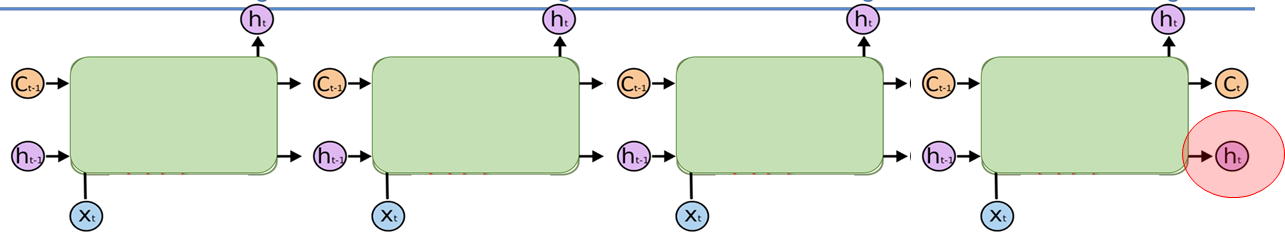

2.   **return_sequences=True :** All Hidden States (Hidden State of ALL the time steps)


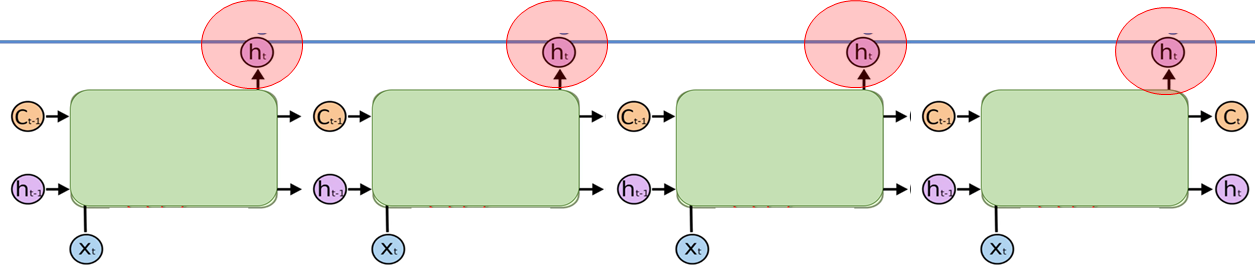

3.   **return_state=True     :** Last Hidden State+ Last Hidden State (again!) + Last Cell State (Cell State of the last time step)


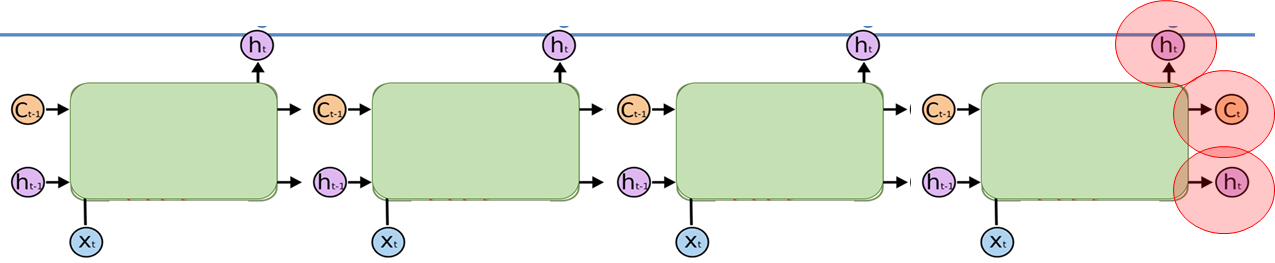

4. **return_sequences=True + return_state=True:** All Hidden States (Hidden State of ALL the time steps) + Last Hidden State  + Last Cell State (Cell State of the last time step)




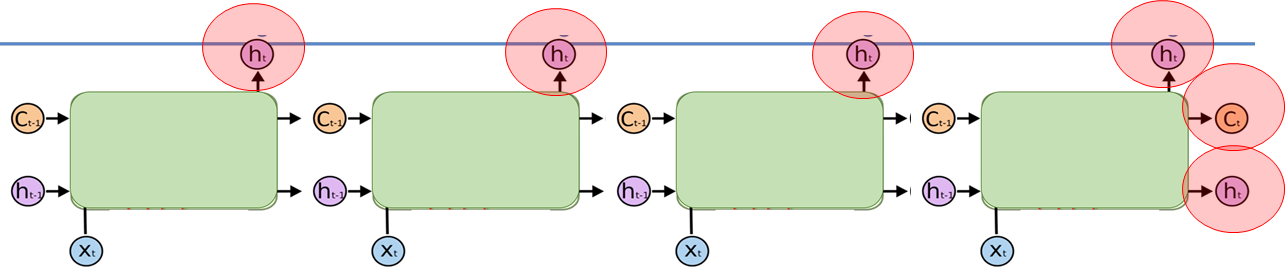

Using these 4 different results/states we can stack  LSTM layers in various ways


**IMPORTANT:** If you are **not familiar with LSTM**, you would like to consider refreshing your knowledge by watching / reading below resources:

**Videos:**
* [LSTM: From A Programmer's Perspective](https://youtu.be/7nnSjZBJVDs)

**Notebooks**:
* [LSTM: From A Programmer's Perspective](https://colab.research.google.com/drive/1kG5pUczEtqdDtMHiNL-mvgTi-5-Y058t?usp=sharing)
* [LSTM: Understanding Output Types](https://colab.research.google.com/drive/1nUazJkXcRZi-XiXCr6sEgCy2Z5Mhze1n?usp=sharing)

##**IMPORTANT: USE OF FUNCTIONAL KERAS API:** 
* In order to implement Encoder-Decoder approach, we will use **Keras Functional API** to create train & inference models

* Thus, ensure that you are familiar with **Keras Functional API**

## 1. Understand & apply context vector
Context vector is 
* the **encoded version** of the input sequence
* the **new representation** of the input sequence
* the **summary** of the input sequence
* the **last** (**hidden & cell**) states  of the **encoder**
* the **initial** (**hidden & cell**) states  of the **decoder**
But,
* **NOT** the output of the encoder

Therefore, in the **encoder LSTM** we will use **return_state=True** for getting the **last Hidden and Cell states**.

![link text](https://blog.keras.io/img/seq2seq/seq2seq-inference.png)

[Image taken from here](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

### Decide the context (latent) vector dimension
* Actually it is the **number of LSTM units** parameter of the LSTM layer in Keras.
* As the **context vector** is the condensed representation of the whole input sequence mostly we prefer a large dimension.
* We can **increment the context (latent) vector dimension** by 2 ways:
  * increment the number of **units** in encoder LSTM
  * and/or increment the **number of encoder LSTM layers**
* For the sake of simplicity, we use **single LSTM layer** ***in encoder and decoder layers*** for the time being


In [9]:
#@title numberOfLSTMunits in other words Output Dimension of the encoder LSTM
numberOfLSTMunits = 16 #@param {type:"integer"}


time: 1.12 ms


### Define the Encoder by using LSTM layer
* Notice that **output** of the encoder is the **last hidden states and cell states** of the LSTM cell
* **return_states=True** ***returns***: Last Hidden State+ Last Hidden State (again!) + Last Cell State (Cell State of the last time step)
* Since we will have **last hidden states** twice, we can ignore the first one (actually this one is considered as the ***output*** of the LSTM in general!) .
* In other words, we **ignore** the ***output*** of the encoder LSTM but **use** the **last Hidden and Cell states**.

* That output is the **context/thougth** (latent) vector
* By using the **context** vector, we will **set** the initial states of **the decoder LSTM**.
* That is decoder will start to function with the last state of the encoder 




#### A Sample Encoder
* Can you imagine the dimension of the context vector?

In [10]:
# Define the encoder layers
encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
encoder_lstm = LSTM(numberOfLSTMunits, return_state=True,  name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
states = [state_h, state_c]

time: 415 ms


* As seen above, encoder **LSTM with return_state=True** returns 3 tensors:
** last hidden state: encoder_outputs
** last hidden state (again!): state_h
** last cell state : state_c
* The **dimension** of each state equals to the **LSTM unit number**




In [11]:
encoder_lstm.output_shape

[(None, 16), (None, 16), (None, 16)]

time: 3.51 ms


* **Context** vector  generally is **[state_h , state_c]**. 
* In the LSTM, these values are actually the last states of the encoder LSTM.



In [12]:
# Define and compile model first
model_encoder = Model(encoder_inputs, states) 
context_vector= model_encoder(X)
print('X.shape: ', X.shape)
print('numberOfLSTMunits: ', numberOfLSTMunits)
print(' last hidden states',context_vector[0].numpy().shape)
print(' last cell states',context_vector[1].numpy().shape)

X.shape:  (1, 4, 10)
numberOfLSTMunits:  16
 last hidden states (1, 16)
 last cell states (1, 16)
time: 81.2 ms


### Define the Decoder LSTM
* We can use context vector, here [state_h , state_c], to initialize the decoder LSTM
* We set up our decoder LSTM to return **all hidden states**, and to return **cell states** as well by setting **return_sequences** and    **return_state parameters** to ***True***



In [13]:
# Set up the decoder, which will only process one timestep at a time.
decoder_inputs = Input(shape=(1, n_features), name='decoder_inputs')
decoder_lstm = LSTM(numberOfLSTMunits, return_sequences=True, 
                    return_state=True, name='decoder_lstm')
decoder_dense = Dense(n_features, activation='softmax')

outputs, state_h, state_c = decoder_lstm(decoder_inputs,initial_state=states)

time: 215 ms


In [14]:
decoder_lstm.output_shape

[(None, 1, 16), (None, 16), (None, 16)]

time: 4.06 ms


* Now decoder is ready to process the data: **BUT WHICH DATA?**
* **Input** data is **already consumed** by **Encoder** and converted into a context vector.
* Context vector is already consumed as initial states of the decoder (LSTM)
* **So what is the input for decoder?**

* Remeber the problem: reversing the input sequence.
So we have **input X** any **output y** as below:

In [15]:
#@title Sample X and y

print('\nIn raw format:')
print('X=%s' % (one_hot_decode(X[0])))
print('y=%s' % (one_hot_decode(y[0])))
print('\nIn one_hot_encoded format:')
print('X=%s' % (X[0]))
print('y=%s' % (y[0]))


In raw format:
X=[1, 9, 7, 7]
y=[7, 7, 9, 1]

In one_hot_encoded format:
X=[[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]]
y=[[0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]]
time: 8.57 ms


### HOW ENCODER - DECODER WOULD WORK IN INFERENCE
Encoder:
* Receives the input sequence
* It consumes the tokens at each time steps
* After finishing all tokens in the input sequence, Encoder outputs **last hidden & cell states** ***as the context vector***.
* Encoder stops 

Decoder:
* Decoder produce the output sequece one by one 
* For each output, the decoder consumes a context vector and an input
* The **initial context** vector is created by the **encoder**
* The **initial input to the decoder** is a special symbol for decoder to make it start, e.g. '***zero***'
* Using initial context and initial input, the decoder will generate/predict the **first output**
* For the next time step, decoder will use  **its own last hidden & cell states** ***as context vector*** and **generated/predicted output at the previous time step** as ***input***
* Decoder will work in such a **loop** using its states and output as the next step context vector and input **until**:
  * the generated output is a special symbol (e.g. '***STOP***' or '***END***') or 
  * the ***pre-defined maximum steps*** (length of output) is reached.



In [16]:
#@title How it works?

from IPython.display import Image
Image(url='https://nextjournal.com/data/Qmc1KsqbPiPqP6dyA3niRnZ4StznJzx28d9FRdipYEZJx4?filename=Seq2Seq%20Model%20Animation.gif&content-type=image/gif')

time: 3.69 ms


[Animation is taken here](https://nextjournal.com/gkoehler/machine-translation-seq2seq-cpu)

###REMINDER: TYPES OF SEQ2SEQ PROBLEMS:
* According to the **length** of input & output sequences, these lengths can be **fixed** or **variable**

* In the ***reversing input sequence problem***, input & output sequence lengths are **fixed** and **same**. We have ***n_timesteps_in*** tokens in input & output sequences.

* Therefore, the decoder in our solution will stop after producing pre-determined number of tokens (outputs). That is, we do not need '**STOP**' or '**END**' symbol in this problem.

* However, decoder will begin to work with '**START**' symbol. We reserve the **0 (zero)** as the 'START' symbol. Therefore, we **DID NOT**  use 0 (zero) as a token while creating sequence samples.

* In summary, we will **condition** the decoder to start with **context vector** and '**START**' symbol to predict output sequence as many as ***n_timesteps_in***.


### HOW TO TRAIN & TEST ENCODER - DECODER 
* We need 2 input sequences:
1. Input for encoder: ***encoder_inputs***
2. Input for decoder: ***decoder_inputs***

The ***encoder_inputs*** is given in the problem as a sequence. We will supply them directly to the Encoder.

Encoder:
* receives the input sequence
* consumes the tokens at each time steps
* outputs **last hidden & cell states** ***as the context vector*** after finishing all tokens in the input sequence
* stops 


 For ***decoder_inputs***  we will provide '***START***' token as the ***initial input***.

Decoder:
* predicts the first time step ouput consuming ***the context vector*** provided by Encoder and ***initial input***.
* consumes the **predicted output** as the **next input**,  **its previous last hidden & cell states** ***as the context vector*** for the next time steps
* stops when the required number of tokens outputed, since, **in our problem**, input and output sequences have  **fixed and same** sizes 


#### CREATE A MODEL INCLUDING ENCODER & DECODER


Define A model in which
* Encoder receives `encoder input data` and converts it to a context vector 
* Decoder runs in a loop:
 * Decoder is initialized with context vector and recives `decoder input data`
 * Decoder converts  `decoder input data` to one time step output
 * Decoder also outputs its hidden states and cell states as context vector
 * in the next cycle of the loop, decoder use its states and output as the input for itself (the context vector and the input) 


**IMPORTANT**: You can access and run [the full code on Colab](https://colab.research.google.com/drive/1ErnVEZOmlu_nInxaoLStW0BHzgT4meVj?usp=sharing).

In [17]:
def create_hard_coded_decoder_input_model(batch_size):
  # The first part is encoder
  encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
  encoder_lstm = LSTM(numberOfLSTMunits, return_state=True,  name='encoder_lstm')
  encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
  
  # initial context vector is the states of the encoder
  states = [state_h, state_c]
  
  # Set up the decoder layers
  # Attention: decoder receives 1 token at a time &
  # decoder outputs 1 token at a time 
  decoder_inputs = Input(shape=(1, n_features))
  decoder_lstm = LSTM(numberOfLSTMunits, return_sequences=True, 
                      return_state=True, name='decoder_lstm')
  decoder_dense = Dense(n_features, activation='softmax',  name='decoder_dense')

  all_outputs = []
  # Prepare decoder initial input data: just contains the START character 0
  # Note that we made it a constant one-hot-encoded in the model
  # that is, [1 0 0 0 0 0 0 0 0 0] is the initial input for each loop
  decoder_input_data = np.zeros((batch_size, 1, n_features))
  decoder_input_data[:, 0, 0] = 1 
  
  # that is, [1 0 0 0 0 0 0 0 0 0] is the initial input for each loop
  inputs = decoder_input_data
  # decoder will only process one time step at a time
  # loops for fixed number of time steps: n_timesteps_in
  for _ in range(n_timesteps_in):
      # Run the decoder on one time step
      outputs, state_h, state_c = decoder_lstm(inputs,
                                              initial_state=states)
      outputs = decoder_dense(outputs)
      # Store the current prediction (we will concatenate all predictions later)
      all_outputs.append(outputs)
      # Reinject the outputs as inputs for the next loop iteration
      # as well as update the states
      inputs = outputs
      states = [state_h, state_c]

  # Concatenate all predictions such as [batch_size, timesteps, features]
  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

  # Define and compile model 
  model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

time: 42.1 ms


* Let's create the model by calling the function and check the model summary & plot 

Model: "model_encoder_decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 16), (None,  1728        encoder_inputs[0][0]             
__________________________________________________________________________________________________
tf_op_layer_MatMul_1 (TensorFlo [(None, 64)]         0           encoder_lstm[0][1]               
__________________________________________________________________________________________________
tf_op_layer_AddV2_2 (TensorFlow [(10, 64)]           0           tf_op_layer_MatMul_1[0][0]       
______________________________________________________________________________

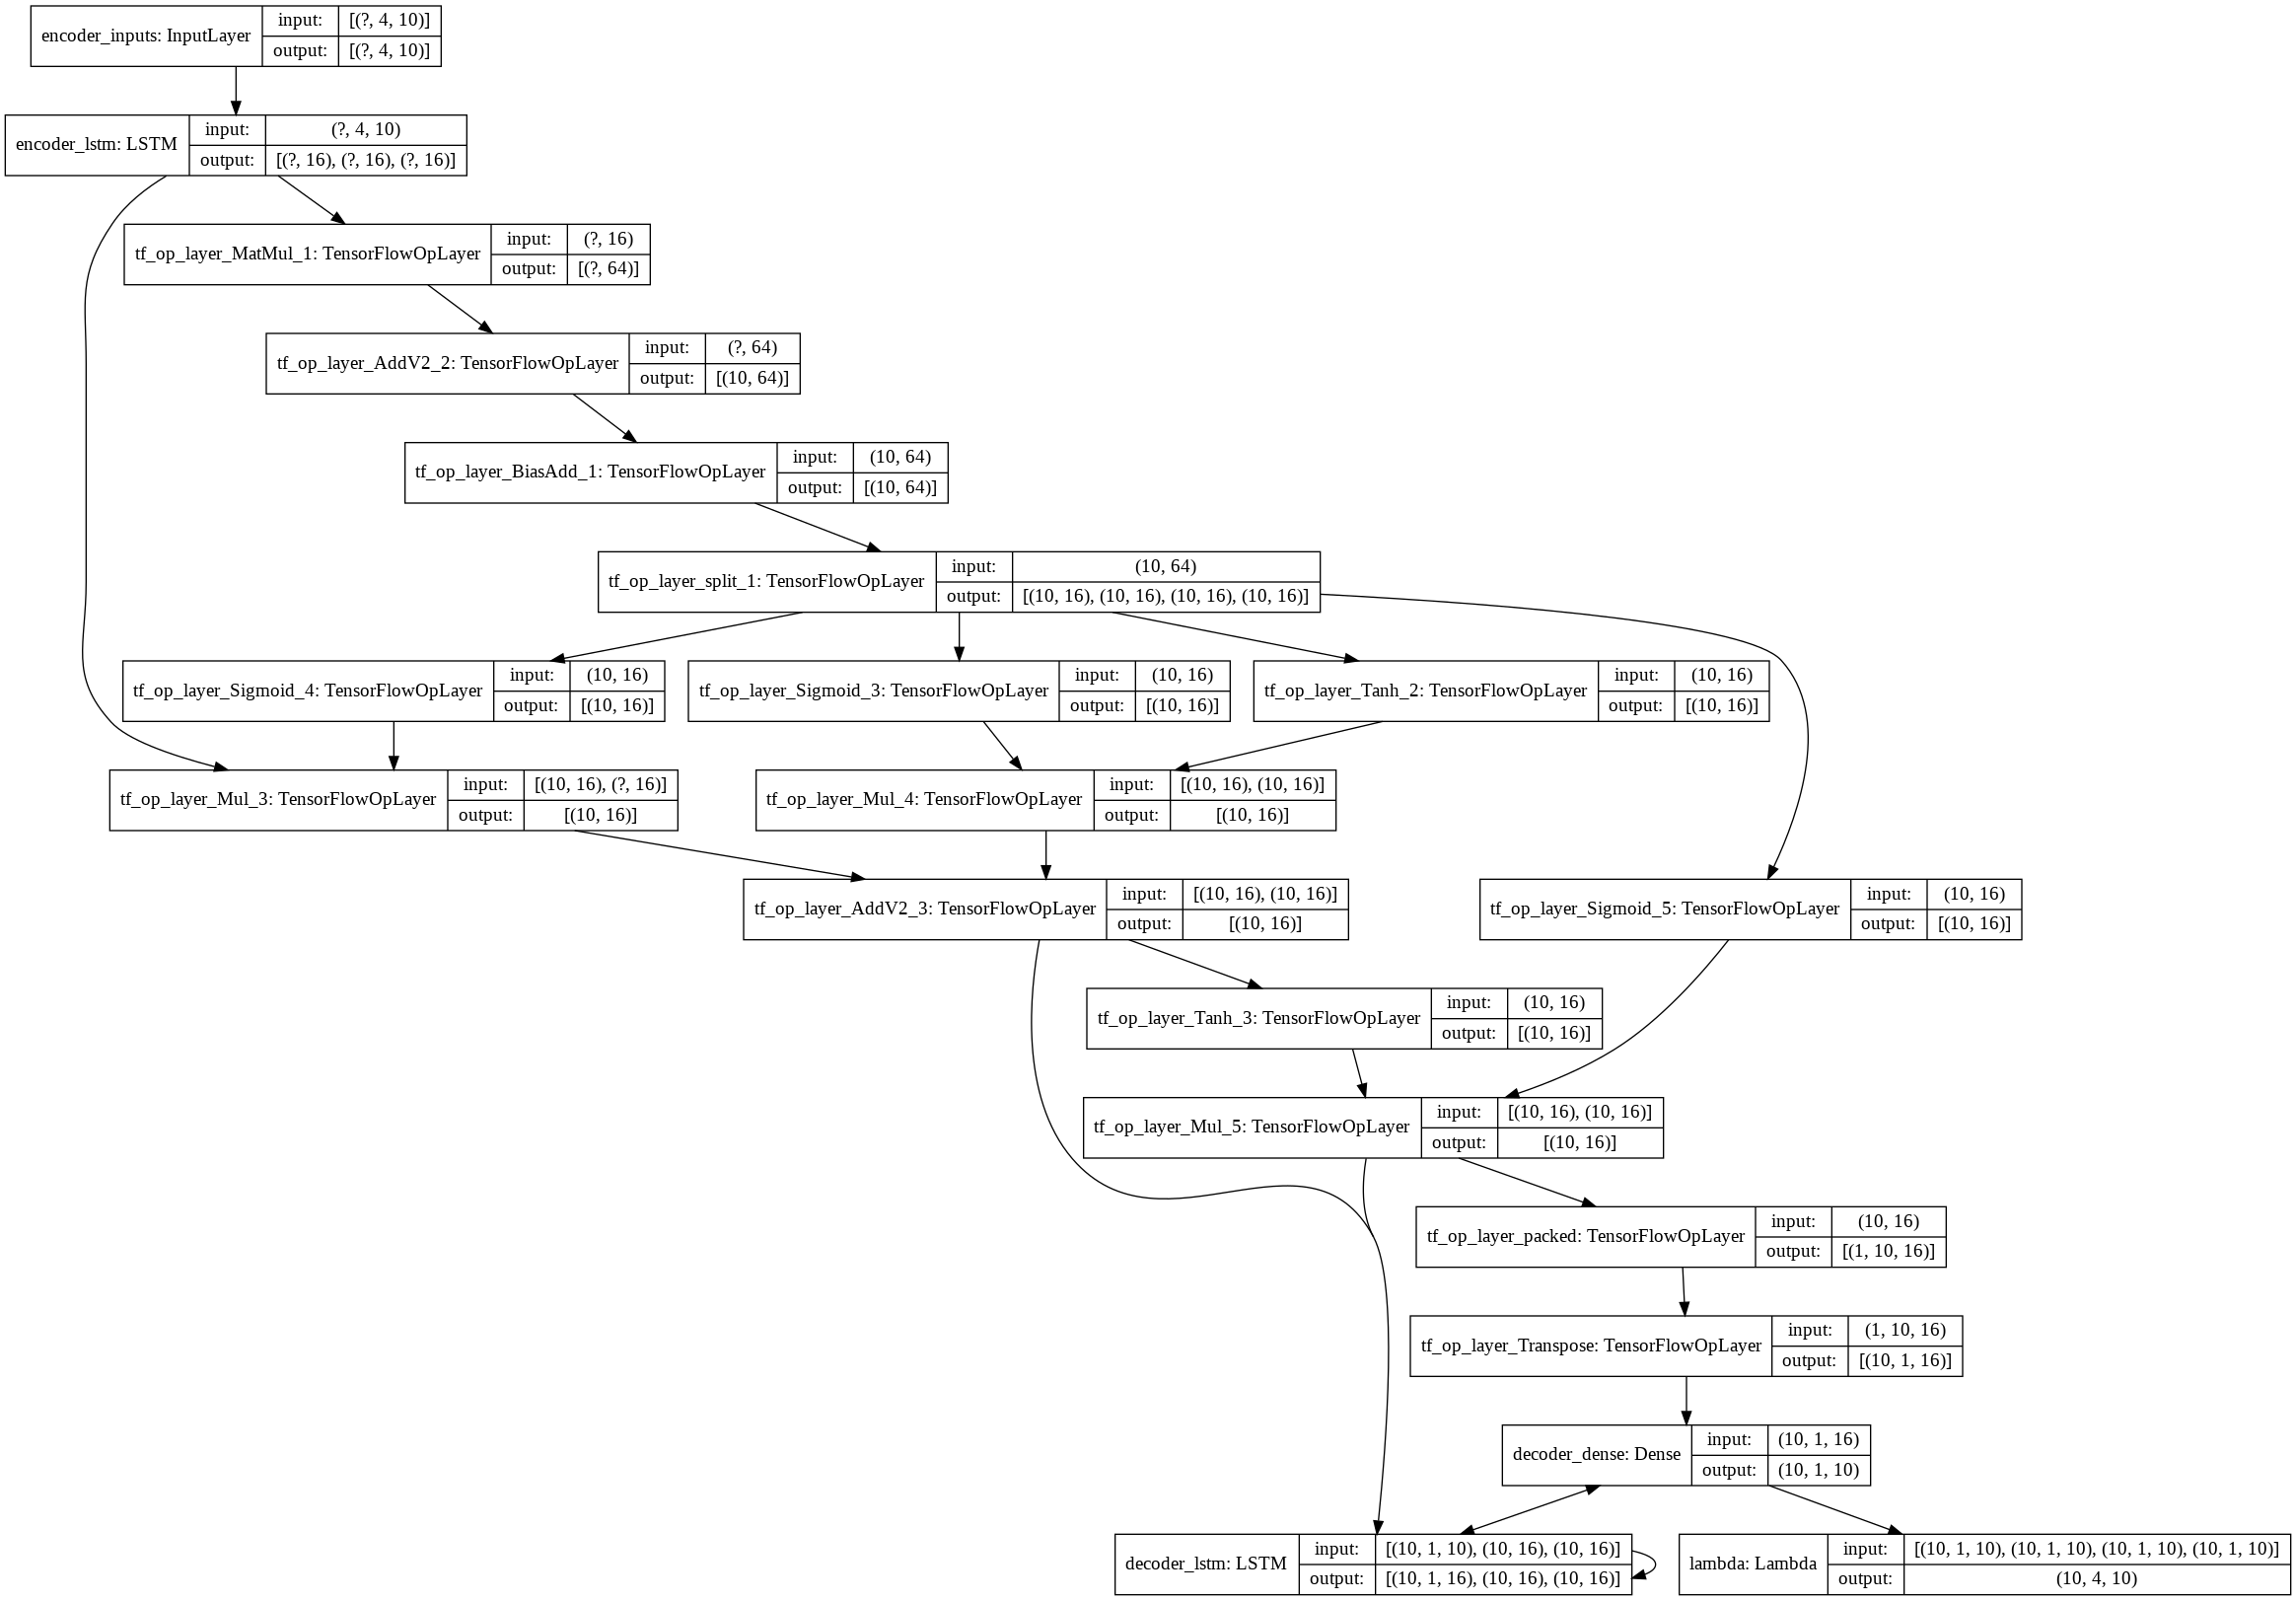

time: 1.57 s


In [18]:
batch_size = 10
model_encoder_decoder=create_hard_coded_decoder_input_model(batch_size=batch_size)
model_encoder_decoder.summary()
plot_model(model_encoder_decoder, show_shapes=True)

# Train model 
```python
model_encoder_decoder.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=30,
          validation_split=0.2)
```

We can run the compiled model as shown above. However, I will use the auxiliary function "**train_test()**" that I prepared for caring training and testing of a given model with Early Stopping mechanism. 

**IMPORTANT**: You can access and check [train_test() function & the full code on Colab](https://colab.research.google.com/drive/1ErnVEZOmlu_nInxaoLStW0BHzgT4meVj?usp=sharing).

training for  500  epochs begins with EarlyStopping(monitor= val_loss, patience= 5 )....
Epoch 1/500
180/180 [==============================] - 2s 11ms/step - loss: 2.2124 - accuracy: 0.2200 - val_loss: 2.0893 - val_accuracy: 0.3038
Epoch 2/500
180/180 [==============================] - 1s 4ms/step - loss: 1.9055 - accuracy: 0.3432 - val_loss: 1.7605 - val_accuracy: 0.3400
Epoch 3/500
180/180 [==============================] - 1s 4ms/step - loss: 1.6748 - accuracy: 0.3660 - val_loss: 1.6112 - val_accuracy: 0.3738
Epoch 4/500
180/180 [==============================] - 1s 4ms/step - loss: 1.5634 - accuracy: 0.3817 - val_loss: 1.5273 - val_accuracy: 0.3800
Epoch 5/500
180/180 [==============================] - 1s 4ms/step - loss: 1.4925 - accuracy: 0.3964 - val_loss: 1.4635 - val_accuracy: 0.3850
Epoch 6/500
180/180 [==============================] - 1s 4ms/step - loss: 1.4352 - accuracy: 0.4076 - val_loss: 1.4080 - val_accuracy: 0.4012
Epoch 7/500
180/180 [==============================]

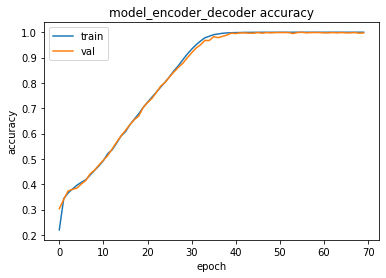

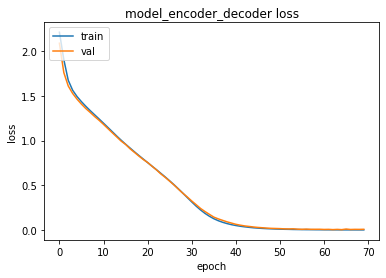

10 examples from test data...
Input          Expected       Predicted         T/F
[2, 1, 4, 2]   [2, 4, 1, 2]   [2, 4, 1, 2]   True
[6, 5, 1, 6]   [6, 1, 5, 6]   [6, 1, 5, 6]   True
[6, 4, 9, 1]   [1, 9, 4, 6]   [1, 9, 4, 6]   True
[2, 5, 8, 7]   [7, 8, 5, 2]   [7, 8, 5, 2]   True
[5, 2, 9, 7]   [7, 9, 2, 5]   [7, 9, 2, 5]   True
[4, 2, 3, 1]   [1, 3, 2, 4]   [1, 3, 2, 4]   True
[2, 2, 9, 3]   [3, 9, 2, 2]   [3, 9, 2, 2]   True
[5, 6, 9, 7]   [7, 9, 6, 5]   [7, 9, 6, 5]   True
[3, 8, 7, 1]   [1, 7, 8, 3]   [1, 7, 8, 3]   True
[9, 1, 3, 9]   [9, 3, 1, 9]   [9, 3, 1, 9]   True
Accuracy:  1.0
time: 1min 2s


In [19]:
train_test(model_encoder_decoder, X_train, y_train , X_test, 	y_test, batch_size=batch_size,epochs=500, verbose=1)

# OBSERVATIONS
* We use LSTM as the Recurrent Nueral Network in the model
* We set LSTM parameters: return_sequences and return_state according to the design of Encoder Decoder model
* We implement the model with a single LSTM layer in Encoder and Decoder parts.
* We created an encoder decoder model for a **fixed** size input/output sequences
* **Encoder** consumes all the input sequence and creates a **context vector**
* **Decoder** use the **context vector** created by the Encoder and a special sign **'START'** to output the **initial** token in the output sequence
* **Decoder works in a loop**
* At each cycle of the loop, Decoder generates a token in the output sequence
* To create the next token, decoder use its **last output** and **last hidden & cell states** as input and context vector to itself respectively
* When the fixed size output tokens are created decoder stops

# Do it yourself:
* You can observe the effects of changing the numbers of
  * LSTM cell 
  * LSTM layer 
  * Sequence length

* You can use multiple LSTM layers in encoder and/or decoder


In the next part, we will **improve** training process of the Encoder Decoder model by implementing **Teacher Forcing** 

# Part D: SEQ2SEQ LEARNING WITH AN ENCODER DECODER MODEL + TEACHER FORCING